# Note On RNN

There are two way to train RNN
1. Statelsss - Ordinary Backprop
2. Stateful - Backprop through Time, Truncated Backprop through Time

In [387]:
import torch
import pandas as pd
from torch import nn,optim
import torch.utils.data as data
import matplotlib.pyplot as plt
# Get cpu, gpu or mps device for training.
device = (
    "cuda" 
    if torch.cuda.is_available() else "mps"
    if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [388]:
# source : https://www.kaggle.com/datasets/rakannimer/air-passengers
df = pd.read_csv('data/AirPassengers.csv')
df

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


<Axes: >

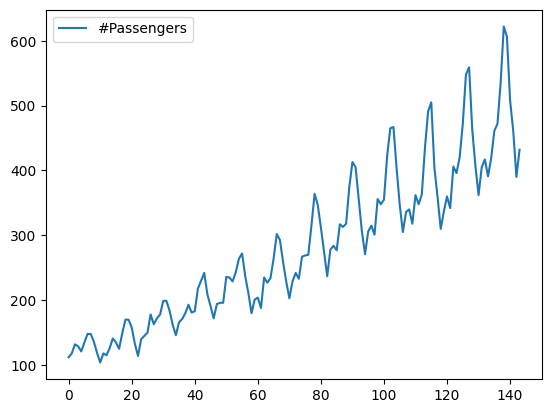

In [389]:
df.plot()

In [390]:
train_size = int(len(df)*0.67)
train_dataset = df.iloc[:train_size]
test_dataset = df.iloc[train_size:]

In [391]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [392]:
lookback = 5
X_train, y_train = create_dataset(train_dataset['#Passengers'].values, lookback=lookback)
X_test, y_test = create_dataset(test_dataset['#Passengers'].values, lookback=lookback)
reshaper = lambda x : x.reshape(x.size(0),-1,1).float()
X_train, y_train,X_test, y_test = tuple(reshaper(tmp).to(device) for tmp in (X_train, y_train,X_test, y_test))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([91, 5, 1]) torch.Size([91, 5, 1])
torch.Size([43, 5, 1]) torch.Size([43, 5, 1])


In [393]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        # LSTM also receive
        #   h - hidden state
        #   c - cell state
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self,x,state=None):
        # x : (batch_sz,seq_len,input_sz)
        # h,c : (n_layers,batch_sz,hidden_sz)
        x,(h,c) = self.lstm(x,state)
        #  x : (batch_sz,seq_len,hidden_sz),
        # h,c : (n_layers,batch_sz,hidden_sz)
        x = self.linear(x)
        return x,(h,c)
    def init_hidden(self,batch_sz=1):
        # h,c : (n_layers,batch_sz,hidden_sz)
        num_layers = self.lstm.num_layers
        hidden_sz = self.lstm.hidden_size
        return (torch.zeros(num_layers,batch_sz, hidden_sz),
                torch.zeros(num_layers,batch_sz, hidden_sz))

In [394]:
model = AirModel().to(device)
loss_fn = nn.MSELoss()  
# drop_last is necessary because ... 
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8,drop_last=True)

h,c = model.init_hidden(8)
h,c = h.to(device),c.to(device)
i = 0
for X,y in loader:
    print('--in--')
    print(X.shape,h.shape,c.shape)
    print('--mid--')
    out,(h,c) = model(X,(h,c))
    print('--out--')
    print(out.shape,h.shape,c.shape)
    break
    i += 1
    if i > 2: break

--in--
torch.Size([8, 5, 1]) torch.Size([1, 8, 50]) torch.Size([1, 8, 50])
--mid--
--out--
torch.Size([8, 5, 1]) torch.Size([1, 8, 50]) torch.Size([1, 8, 50])


In [395]:
def train_through_time(model,loader,loss_fn,optimizer):
    model.train()
    state = model.init_hidden(loader.batch_size)
    state = [each.to(device) for each in state]
    for X_batch, y_batch in loader:
        y_pred,state = model(X_batch,state)
        state = [each.data for each in state]
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [396]:
def train(model,loader,loss_fn,optimizer):
    model.train()
    for X_batch, y_batch in loader:
        y_pred,_ = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [397]:
model = AirModel().to(device)
optimizer = optim.Adam(model.parameters())
train_losses = []
test_losses = []
n_epochs = 1500
for epoch in range(n_epochs):
    model.train()
    train(model,loader,loss_fn,optimizer)
    
    with torch.no_grad():
        model.eval()
        y_pred,_ = model(X_train)
        train_rmse = loss_fn(y_pred, y_train).sqrt().item()
        train_losses.append(train_rmse)
        y_pred,_ = model(X_test)
        test_rmse = loss_fn(y_pred, y_test).sqrt().item()
        test_losses.append(test_rmse)
    
    if epoch%100 == 0:
        print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

Epoch 0: train RMSE 225.8413, test RMSE 425.6277
Epoch 100: train RMSE 179.3883, test RMSE 376.9644
Epoch 200: train RMSE 144.0222, test RMSE 338.4924
Epoch 300: train RMSE 114.7611, test RMSE 304.3115
Epoch 400: train RMSE 92.5335, test RMSE 274.4255
Epoch 500: train RMSE 72.4772, test RMSE 245.2470
Epoch 600: train RMSE 57.9963, test RMSE 219.2487
Epoch 700: train RMSE 46.9154, test RMSE 196.1465
Epoch 800: train RMSE 39.0561, test RMSE 175.5758
Epoch 900: train RMSE 32.8115, test RMSE 156.2753
Epoch 1000: train RMSE 28.6330, test RMSE 139.9621
Epoch 1100: train RMSE 25.7172, test RMSE 126.6719
Epoch 1200: train RMSE 23.7849, test RMSE 115.1346
Epoch 1300: train RMSE 21.9846, test RMSE 105.6099
Epoch 1400: train RMSE 21.0431, test RMSE 97.8301
Epoch 1500: train RMSE 20.3058, test RMSE 92.1517
Epoch 1600: train RMSE 19.9366, test RMSE 87.5084
Epoch 1700: train RMSE 19.0639, test RMSE 84.1537
Epoch 1800: train RMSE 18.9066, test RMSE 82.4876
Epoch 1900: train RMSE 18.2333, test RMSE 79

In [398]:
model = AirModel().to(device)
optimizer = optim.Adam(model.parameters())
train_losses2 = []
test_losses2 = []
n_epochs = 1500
for epoch in range(n_epochs):
    model.train()
    train_through_time(model,loader,loss_fn,optimizer)
    
    with torch.no_grad():
        model.eval()
        y_pred,_ = model(X_train)
        train_rmse = loss_fn(y_pred, y_train).sqrt().item()
        train_losses2.append(train_rmse)
        y_pred,_ = model(X_test)
        test_rmse = loss_fn(y_pred, y_test).sqrt().item()
        test_losses2.append(test_rmse)
    
    if epoch%100 == 0:
        print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

Epoch 0: train RMSE 225.7507, test RMSE 425.5527
Epoch 100: train RMSE 180.0110, test RMSE 377.6189
Epoch 200: train RMSE 144.8725, test RMSE 339.4395
Epoch 300: train RMSE 114.7282, test RMSE 304.2682
Epoch 400: train RMSE 93.0166, test RMSE 275.0192
Epoch 500: train RMSE 73.7446, test RMSE 247.0495
Epoch 600: train RMSE 59.0297, test RMSE 219.8486
Epoch 700: train RMSE 49.4136, test RMSE 197.1272
Epoch 800: train RMSE 43.6566, test RMSE 177.4877
Epoch 900: train RMSE 38.7161, test RMSE 161.1206
Epoch 1000: train RMSE 35.4757, test RMSE 146.4789
Epoch 1100: train RMSE 32.6283, test RMSE 134.5067
Epoch 1200: train RMSE 30.1689, test RMSE 124.3690
Epoch 1300: train RMSE 27.9231, test RMSE 117.7136
Epoch 1400: train RMSE 26.8311, test RMSE 109.4394
Epoch 1500: train RMSE 25.0904, test RMSE 105.3625
Epoch 1600: train RMSE 24.5891, test RMSE 102.8288
Epoch 1700: train RMSE 24.2914, test RMSE 97.2415
Epoch 1800: train RMSE 24.7147, test RMSE 94.5291
Epoch 1900: train RMSE 23.6207, test RMSE

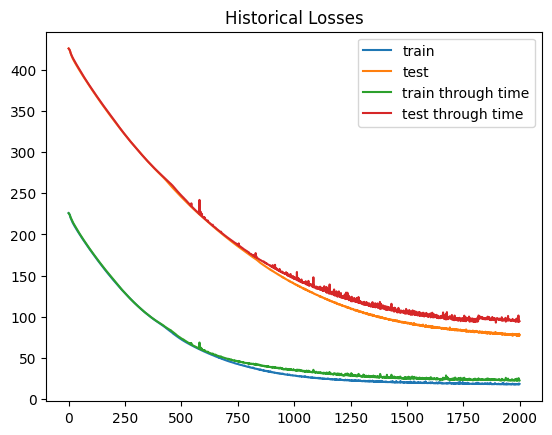

In [399]:
plt.title('Historical Losses')
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.plot(train_losses2, label ='train through time')
plt.plot(test_losses2, label='test through time')
plt.legend()

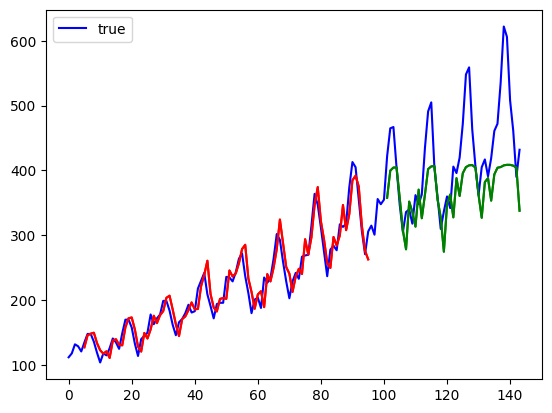

In [400]:
timeseries = df
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    
    y_train_pred,_ = model(X_train)
    train_plot[lookback:train_size] = y_train_pred[:, -1, :].cpu()
    # shift test predictions for plotting
    y_test_pred,_ = model(X_test)
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = y_test_pred[:, -1, :].cpu()
    
# plot
plt.plot(timeseries['#Passengers'], c='b',label='true')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.legend()
plt.show()